In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import importlib
from threading import Thread
import time # for time.sleep
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
# from pyvista import _vtk
import pyvistaqt as pvqt
import colorcet as cc # Colormaps:
import numpy as np
import h5py
import hdf5storage # conda install hdf5storage
from pathlib import Path
import bqplot.scales
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
# import mplcursors
import math # For color map generation
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

import ipywidgets as widgets
# from PyQt5 import QtWidgets, uic
from pyvistaqt import QtInteractor, MainWindow
# from pyqt6 import QApplication
from IPython.external.qt_for_kernel import QtGui
from PyQt5.QtWidgets import QApplication

import datetime as dt
import panel as pn # for interactive widgets
pn.extension()

In [2]:
from PhoPositionalData.load_exported import *
# from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from PhoPositionalData.process_data import *
from PhoPositionalData.plot_data import *
from PhoPositionalData.plotting.animations import * # make_mp4_from_plotter
from PhoPositionalData.import_data import * # build_spike_positions_list, build_cellID_reverse_lookup_map
from PhoPositionalData.analysis.interactive_placeCell_config import InteractivePlaceCellConfig, VideoOutputModeConfig, PlottingConfig, PlacefieldComputationParameters  # VideoOutputModeConfig, InteractivePlaceCellConfigs
from PhoPositionalData.analysis.interactive_placeCell_config import print_subsession_neuron_differences

In [3]:
# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core
    importlib.reload(core)
except ImportError:
    sys.path.append(r'C:\Users\Pho\repos\NeuroPy') # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print('neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.')
    from neuropy import core
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.core.epoch import NamedTimerange
from neuropy.utils.misc import print_seconds_human_readable


neuropy module not found, adding directory to sys.path. 
 >> Updated sys.path.


In [4]:
## Bapun Format:
# basedir = '/media/share/data/Bapun/Day5TwoNovel' # Linux
basedir = Path('R:\data\Bapun\Day5TwoNovel') # Windows
# basedir = '/Volumes/iNeo/Data/Bapun/Day5TwoNovel' # MacOS
sess = DataSessionLoader.bapun_data_session(basedir)
active_sess_config = sess.config
session_name = sess.name
print(sess.epochs.to_dataframe())
print(sess.position.to_dataframe()) # max is in 4.2305 x 10^4
print(sess.flattened_spiketrains.spikes_df) # t_seconds is in the same units as the position dataframe, which is NOT seconds, and 't' is a factor of 1x10^4 larger than 't_seconds'

converting neuron_type strings to core.neurons.NeuronType objects...
	 done.
Issue with pickled POSIX_PATH on windows for path R:\data\Bapun\Day5TwoNovel\RatS-Day5TwoNovel-2020-12-04_07-55-09.probegroup.npy, falling back to non-pickled version...
linearized position loaded from file.
Loading success: .flattened.spikes.npy.
Loading success: .ripple.npy.
Loading success: .mua.npy.
Loading success: .pbe.npy.
   start   stop  label  duration
0      0  11066    pre     11066
1  11070  13970  maze1      2900
3  13972  20754  post1      6782
2  20756  24004  maze2      3248
4  24006  42305  post2     18299
                    t          x  lin_pos          y         z  speed
0            0.000000 -50.946354      NaN -50.646282  7.124897    0.0
1            0.016667 -50.946354      NaN -50.646282  7.124897    0.0
2            0.033333 -50.946354      NaN -50.646282  7.124897    0.0
3            0.050000 -50.946354      NaN -50.646282  7.124897    0.0
4            0.066667 -50.946354      NaN -

In [5]:
## NOTE: The only place that I need to be careful with indexing is with sess.position properties, as these appear to be represented in terms of the number of 60Hz samples instead of in seconds like the Neurons and other classes.
active_epoch_name = 'maze1'
# active_epoch_name = 'maze2'

active_epoch = NamedTimerange(
        name=active_epoch_name,
        start_end_times=sess.epochs[active_epoch_name]
    )

# active_epoch_name = 'maze'
# active_epoch = NamedTimerange(
#         name=active_epoch_name,
#         start_end_times=[sess.epochs['maze1'][0], sess.epochs['maze2'][1]]
#     )
# Constraining to epoch with times (start: 0.0, end: 1932.4200048116618)
# 20996/932598 total spikes spanning 40/64 units remain in subsession

active_subplots_shape = (1,1) # Single subplot
# active_subplots_shape = '1|2' # 1 subplot on left, two on right

## Get the config corresponding to this epoch/session settings:
# active_config = InteractivePlaceCellConfig(active_session_config=active_sess_config, active_epochs=active_epoch)
active_config = InteractivePlaceCellConfig(active_session_config=active_sess_config, active_epochs=active_epoch,
                        video_output_config=VideoOutputModeConfig(active_frame_range=np.arange(11070.0, 13970.0), video_output_parent_dir=Path('output', active_sess_config.session_name, active_epoch.name), active_is_video_output_mode=False),
                        plotting_config=PlottingConfig(output_subplots_shape=active_subplots_shape, output_parent_dir=Path('output', active_sess_config.session_name, active_epoch.name))) # '3|1    
## Looks like the only real outputs are: active_epoch_session_Neurons, active_epoch_pos
active_config.plotting_config.active_output_parent_dir.mkdir(parents=True, exist_ok=True) # makes the directory if it isn't already there

# Get the filtered and time-constrainted session and position data for this epoch:
active_epoch_session = sess.get_neuron_type('pyramidal').time_slice(active_epoch.t_start, active_epoch.t_stop)
print_subsession_neuron_differences(sess.neurons, active_epoch_session.neurons)
active_epoch_session_Neurons, active_epoch_pos, active_epoch_position_times = active_epoch_session.neurons, active_epoch_session.position, active_epoch_session.position.time

Constraining to units with type: pyramidal
Constraining to epoch with times (start: 11070, end: 13970)
102139/16318817 total spikes spanning 52/109 units remain in subsession


Recomputing active_epoch_placefields...
	 done.
Recomputing active_epoch_placefields2D...
	 done.
Saving 1D Placefield image out to "output\RatS-Day5TwoNovel-2020-12-04_07-55-09\maze1\1D Placefields - maze1.pdf"...
done.


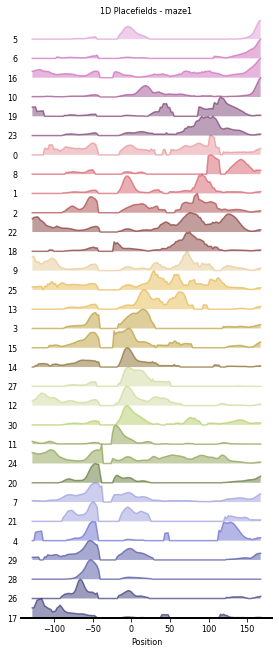

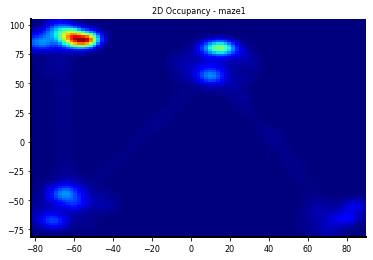

Saving 2D Placefield image out to "output\RatS-Day5TwoNovel-2020-12-04_07-55-09\maze1\2D Occupancy - maze1.pdf"...
	 done.
Saving 2D Placefield image out to "output\RatS-Day5TwoNovel-2020-12-04_07-55-09\maze1\2D Placefields - maze1.pdf"...
	 done.
good_placefield_neuronIDs: [  1   3   9  10  11  13  14  28  34  37  38  39  40  41  42  43  44  47
  48  49  50  52  53  54  55  56  57  58  61  62  63  64  65  68  70  75
  77  80  87  91  93  95 107]; (43 good)


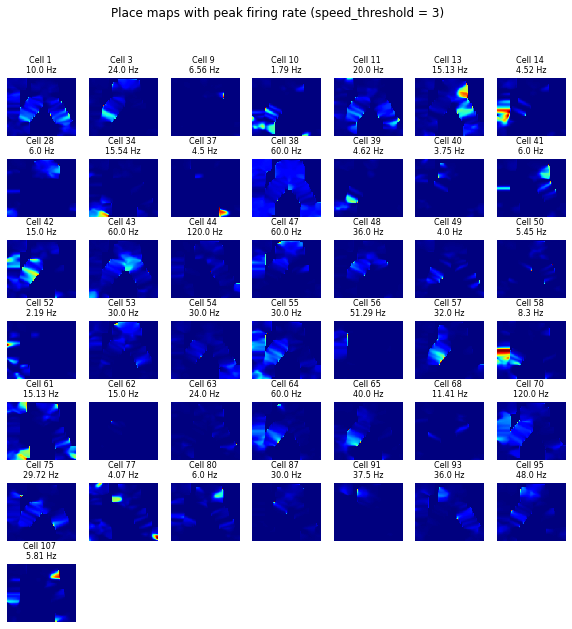

In [6]:
## Compute Placefields if needed:
from neuropy.analyses import Pf1D, Pf2D, perform_compute_placefields, plot_all_placefields
from neuropy.plotting.spikes import get_neuron_colors

should_force_recompute_placefields = True
should_display_2D_plots = True
# Setup the placefield computation config
active_config.computation_config = PlacefieldComputationParameters(speed_thresh=3, grid_bin=2, smooth=2)
try: active_epoch_placefields1D
except NameError: active_epoch_placefields1D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
try: active_epoch_placefields2D
except NameError: active_epoch_placefields2D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
active_epoch_placefields1D, active_epoch_placefields2D = perform_compute_placefields(active_epoch_session_Neurons, active_epoch_pos, active_config.computation_config, active_epoch_placefields1D, active_epoch_placefields2D, should_force_recompute_placefields=True)
# Plot the placefields computed and save them out to files:
if should_display_2D_plots:
    ax_pf_1D, occupancy_fig, active_pf_2D_figures = plot_all_placefields(active_epoch_placefields1D, active_epoch_placefields2D, active_config)
else:
    print('skipping 2D placefield plots')
    
# Focus on the 2D placefields:
active_epoch_placefields = active_epoch_placefields2D
# Get the cell IDs that have a good place field mapping:
good_placefield_neuronIDs = np.array(active_epoch_placefields.ratemap.neuron_ids) # in order of ascending ID
print('good_placefield_neuronIDs: {}; ({} good)'.format(good_placefield_neuronIDs, len(good_placefield_neuronIDs)))

## Filter by neurons with good placefields only:
active_epoch_session = active_epoch_session.get_by_id(good_placefield_neuronIDs) # Filter by good placefields only, and this fetch also ensures they're returned in the order of sorted ascending index ([ 2  3  5  7  9 12 18 21 22 23 26 27 29 34 38 45 48 53 57])
active_epoch_session_Neurons = active_epoch_session.neurons

## Plotting Colors:
def build_units_colormap(session):
    pf_sort_ind = np.array([int(i) for i in np.arange(len(session.neuron_ids))]) # convert to integer scalar array
    pf_colors = get_neuron_colors(pf_sort_ind) # [4 x n_neurons]: colors are by ascending index ID
    pf_colormap = pf_colors.T # [n_neurons x 4] Make the colormap from the listed colors, used seemingly only by 'runAnalysis_PCAandICA(...)'
    pf_listed_colormap = ListedColormap(pf_colormap)
    return pf_sort_ind, pf_colors, pf_colormap, pf_listed_colormap


pf_sort_ind, pf_colors, pf_colormap, pf_listed_colormap = build_units_colormap(active_epoch_session)
active_config.plotting_config.pf_sort_ind = pf_sort_ind
active_config.plotting_config.pf_colors = pf_colors
active_config.plotting_config.active_cells_colormap = pf_colormap
active_config.plotting_config.active_cells_listed_colormap = ListedColormap(active_config.plotting_config.active_cells_colormap)

In [7]:
## ICA and PCA Analysis
should_show_2D_ICA_plots = False
from PhoPositionalData.analysis.neuronal_dimensionality_reduction import runAnalysis_PCAandICA
active_session_ensembles, template, zsc_template, pca_data = runAnalysis_PCAandICA(active_epoch_session_Neurons, bin_size=0.250, frate_thresh=0.1, should_plot=should_show_2D_ICA_plots, active_cells_colormap=active_config.plotting_config.active_cells_colormap)

Based on frate_thresh, excluded neuron_ids: [  9  10  37  40  41  49  50  52  62  68 107]


## Main Spike/Placemap plotting:

# Plot Placemaps on 3D Plot

In [8]:
from PhoGui.InteractivePlotter.InteractivePlaceCellTuningCurvesDataExplorer import InteractivePlaceCellTuningCurvesDataExplorer
try: pActiveTuningCurvesPlotter
except NameError: pActiveTuningCurvesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipcDataExplorer = InteractivePlaceCellTuningCurvesDataExplorer(active_config, active_epoch_session, active_epoch_placefields, pf_colors, extant_plotter=pActiveTuningCurvesPlotter)
pActiveTuningCurvesPlotter = ipcDataExplorer.plot(pActiveTuningCurvesPlotter) # [2, 17449]

Applying custom Pyvista theme.
done.
No extant BackgroundPlotter
Creating a new BackgroundPlotter


C:\Users\Pho\repos\NeuroPy\neuropy\utils\mathutil.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(


num_curr_tuning_curves: 43


## Interactive 3D Spike and Behavior Browser: 

In [16]:
import PhoGui
from PhoGui.InteractivePlotter.PhoInteractivePlotter import PhoInteractivePlotter
from PhoGui.InteractivePlotter.shared_helpers import InteractivePyvistaPlotterBuildIfNeededMixin
from PhoGui.InteractivePlotter.InteractivePlaceCellDataExplorer import InteractivePlaceCellDataExplorer

active_config.plotting_config.show_legend = True

try: pActiveInteractivePlaceSpikesPlotter
except NameError: pActiveInteractivePlaceSpikesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipspikesDataExplorer = InteractivePlaceCellDataExplorer(active_config, active_epoch_session, extant_plotter=pActiveInteractivePlaceSpikesPlotter)
pActiveInteractivePlaceSpikesPlotter = ipspikesDataExplorer.plot(pActivePlotter=pActiveInteractivePlaceSpikesPlotter)

active_epoch_pos.sampling_rate (Hz): 60
longer_spikes_window - curr_view_window_length_samples - 61440
recent_spikes_window - curr_view_window_length_samples - 60
Applying custom Pyvista theme.
done.
done.


In [17]:
pActiveInteractivePlaceSpikesPlotter = ipspikesDataExplorer.plot(pActivePlotter=pActiveInteractivePlaceSpikesPlotter)

No extant BackgroundPlotter
Creating a new BackgroundPlotter
done.
[f] - Focus and zoom in on the last clicked point
shift+click - Drag to pan the rendering scene
ctrl+click - Rotate the scene in 2D
